# Heat conduction and radiation verification
Gmsh version 4.8.0, Elmer v 9.0 and pyelmer v0.3.2 are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Geometry, Mesh

In [2]:
from sphere_2D import mesh

heater_r_in = 0.4
heater_r_out = 0.5
insulation_r_in = 0.9
insulation_r_out = 1
mesh_size = 0.01

ph_heater, ph_insulation, ph_heater_in, ph_heater_out, ph_insulation_in, ph_insulation_out = mesh(heater_r_in, heater_r_out, insulation_r_in, insulation_r_out, mesh_size)

Screenshot of the mesh:
![geometry-mesh](geometry-mesh.png)

## Setup

The inner sphere is heated with a volumetric power of 30 kW.

There is surface-to-surface radiation between inner and outer sphere and inside of the inner one. At the outer sphere there is radiation to ambient with the ambient temperature $T_{amb}=300~\mathrm{K}$.

## Simulation

In [3]:
from sphere_2D import elmer_setup
from pyelmer.execute import run_elmer_grid, run_elmer_solver
from pyelmer.post import scan_logfile

elmer_setup(ph_heater, ph_insulation, ph_heater_in, ph_heater_out, ph_insulation_in, ph_insulation_out)
run_elmer_grid("./simdata", "2d_sphere.msh")
run_elmer_solver("./simdata")
warn, err, stats = scan_logfile("./simdata")
print("Warnings:", warn)
print("Errors:", err)
print("Statistics:", stats)

Wrote sif-file.
Warnings: []
Errors: []
Statistics: {'CPU-time': 4.43, 'real-time': 4.43}


## Analytical solution:
According to [K. Dadzis, Modeling of directional solidification of multicrystalline silicon in a
traveling magnetic field, Dissertation, TU Bergakademie Freiberg, 2012, Online:
http://nbn-resolving.de/urn:nbn:de:bsz:105-qucosa-117492 ] the analytical solution to the problem is given by:
\begin{align}
    T_{i,o} &= \left[ \frac{P}{\sigma_{sb} \epsilon_i 4 \pi r^2_{i,o}}+ T_a^4 \right]^{1/4},\\
    T_i(r) &= T_{i,o} + \frac{P}{4 \pi \lambda_i}\left[ \frac{1}{r} - \frac{1}{r_{i,o}} \right],\\
    \epsilon_{h,i} &= \left(\frac{1}{\epsilon_h} + \frac{r_{h,o}^2}{r_{i,i}^2}\left[\frac{1}{\epsilon_i} - 1\right]\right)^{-1}\\
    T_{h,o} &= \left[ \frac{P}{\sigma_{sb} \epsilon_{hi} 4 \pi r^2_{h,o}} + T^4_{i,i} \right]^{1/4},\\
    T_{h}(r) &= T_{h,o} + \frac{P}{V_h}\frac{1}{3\lambda_{h}} \left[\frac{r^2_{h,o}}{2} - \frac{r^2}{2} + \frac{r^3_{h,i}}{r_{h,o}}-\frac{r^3_{h,i}}{r} \right],
\end{align}
with $r_{i,i}$ and $r_{i,o}$ minimum and maximum radius of the outer "insulation" sphere, $r_{h,i}$ and $r_{h,o}$ min. and max. radiums of the inner "heater" sphere, heating power $P$, ambient Temperatrue $T_a$, Stefan-Boltzmann constant $\sigma_{sb}$, volume of "heater" sphere $V_h$, and emissivity $\epsilon$, heat conductivity $\lambda$ of respective spheres; $\epsilon_{h,i}$ effective emissivity between inner and outer sphere.

In [4]:
P = 30000
T_amb = 300

eps_i = 0.5
eps_h = 0.8
lmbd_i = 0.5
lmbd_h = 20
sgm_sb = 5.670374419e-8

r_hi = heater_r_in
r_ho = heater_r_out
r_ii = insulation_r_in
r_io = insulation_r_out

In [5]:
T_io = (P/(sgm_sb*eps_i*4*np.pi * r_io**2) + T_amb**4)**0.25
print(T_io)

551.193934227456


In [6]:
def T_i(r):
    return T_io + P/(4*np.pi*lmbd_i)*(1/r - 1/r_io)
T_ii = T_i(r_ii)
print(T_ii)

1081.7104112004408


In [7]:
eps_hi = 1/( 1/eps_h + r_ho**2/r_ii**2 * (1/eps_i - 1) )
T_ho = (P/(sgm_sb*eps_hi*4*np.pi * r_ho**2) + T_ii**4)**0.25
print(T_ho)

1130.1975139572535


In [8]:
V_h = 4/3 * np.pi * (r_ho**3 - r_hi**3)
def T_h(r):
    return T_ho + P/(V_h*3*lmbd_h)*(r_ho**2/2 - r**2/2 + r_hi**3/r_ho - r_hi**3/r)
print(T_h(r_hi))

1155.6362138776794


## Comparison

Manual evaluation of numerically computed heat flux using ParaView, PlotOverLine, Save Data in csv format (extract-data.psvm).

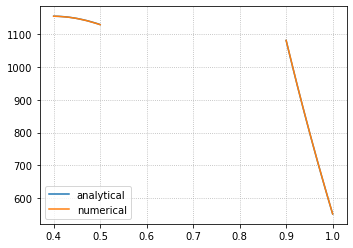

In [9]:
# analytical
r_i = np.linspace(r_ii, r_io, 100)
r_h = np.linspace(r_hi, r_ho, 100)

# numerical
df = pd.read_csv('./simdata/line-data.csv')
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
ax.grid(linestyle=":")
l1, = ax.plot(r_i, T_i(r_i), color="#1f77b4")
l2, = ax.plot(r_h, T_h(r_h), color="#1f77b4")

l3, = ax.plot(df['Points:0'], df['temperature'], color="#ff7f0e")

ax.legend([l1, l3], ["analytical", "numerical"])
# ax.legend()
# ax.set_xlabel('radius [m]')
# ax.set_ylabel('joule heat $\\left[\\frac{\\mathrm{MW}}{\mathrm{m}^3}\\right]$')
# fig.tight_layout()
# fig.savefig("verification_joule-heat.png")
# plt.show()